# Resources

Brilliant talk by Ben Moseley on PINN:
https://www.youtube.com/watch?v=G_hIppUWcsc

# Install necessary pip modules/packages

Using good ipynb practise:
https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

Install the necessary pip packages and modules using pip in the virtual environment (ensure README.md has been followed):

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

Import the necessary packages and modules:

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Check that cuda and gpu is available.

In [3]:
torch.cuda.is_available()
torch.cuda.device_count()

1

# Analytic solution to damped harmonic oscillator

In [4]:
def exact_solution_underdamped(d, w0, t):
    assert d < w0  # ensure under-damped case (gives oscillatory motion)

    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)  # phase
    
    exp_term = np.exp(-d*t)
    A = 1.0/(2.0*np.cos(phi))
    cos_term = np.cos(phi + w*t)

    u = exp_term * 2.0 * A * cos_term
    return u

Assume m=1 then:

d = mu/(2*m)    =>  mu = 2d
w0 = sqrt(k/m)  =>  k = w0**2

Plot some of the exact solutions to get a feel for the solution.

In [5]:
t_test1 = np.linspace(0, 1, 300)

# Control case: d, w0 = 2, 20
d, w0 = 2, 20
mu, k = 2.0*d, w0**2
u_exact_d_2_w0_20 = exact_solution_underdamped(d, w0, t_test1)

# Higher damping (higher d):  d, w0 = 4, 20
d, w0 = 4, 20
mu, k = 2.0*d, w0**2
u_exact_d_4_w0_20 = exact_solution_underdamped(d, w0, t_test1)

# Higher spring constant (higher w0):  
d, w0 = 2, 40
mu, k = 2.0*d, w0**2
u_exact_d_2_w0_40 = exact_solution_underdamped(d, w0, t_test1)

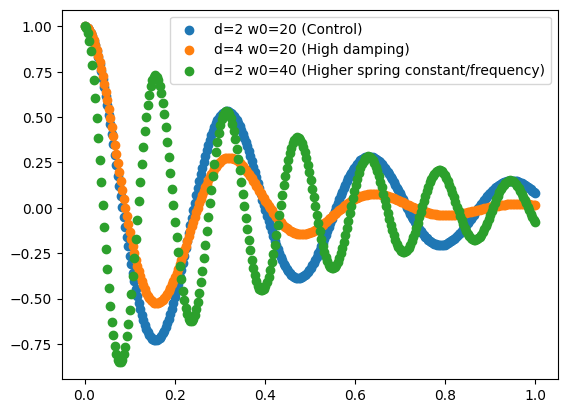

In [6]:
plt.scatter(t_test1, u_exact_d_2_w0_20, label="d=2 w0=20 (Control)")
plt.scatter(t_test1, u_exact_d_4_w0_20, label="d=4 w0=20 (High damping)")
plt.scatter(t_test1, u_exact_d_2_w0_40, label="d=2 w0=40 (Higher spring constant/frequency)")
plt.legend()
plt.show()

# Simple fully connected neural network

Define a simple, fully connected neural network with variable number of hidden layers.  This NN will be trained on the analytic results using the physics-informed loss function (not defined yet) which is composed of 2 loss terms: L_data and L_model.  Furthermore, the L_model can be broken down in the boundary loss, L_boundary, and the physics loss, L_physics.

In [7]:
class fully_connected_network(nn.Module):
    """
    Define a simple fully-connected network in Pytorch with takes a 1D tensor as input and outputs a 1D tensor as output.
    
    Arguments:
    - n_input  : size of the input 1D tensor
    - n_output : size of the output 1D tensor
    - n_hidden : size of the 1D hidden layers
    - n_hidden_layers : number of hidden layers
    """
    
    def __init__(self, n_input, n_output, n_hidden, n_hidden_layers):
        super(fully_connected_network, self).__init__()
        
        activation = nn.Tanh
        
        self.fc_in = nn.Sequential(
            *[
                nn.Linear(n_input, n_hidden),
                activation()
            ]
        )

        self.fc_hidden = nn.Sequential(
            *[
                nn.Sequential(*[nn.Linear(n_hidden, n_hidden), activation()]) for _ in range(0, n_hidden_layers-1)
            ]
        )

        self.fc_out = nn.Linear(n_hidden, n_output)
    
    """ 
    Define the forward pass (input -> output) for this neural network.
    The forward() function/method must be defined for a Pytorch nn.Module in order for automatic differentiation to work.
    """
    def forward(self, x):
        x = self.fc_in(x)
        x = self.fc_hidden(x)
        x = self.fc_out(x)

        return x

Test the network with random data.

In [8]:
print(fully_connected_network)

for i in range(0, 100):
    random_data = torch.rand((5))
    print("random_data: ", random_data)

    test_nn_1 = fully_connected_network(5, 2, 10, 10)
    result = test_nn_1(random_data)
    print("result: ", result)

<class '__main__.fully_connected_network'>
random_data:  tensor([0.8677, 0.1000, 0.9997, 0.4654, 0.8327])
result:  tensor([0.0410, 0.0385], grad_fn=<ViewBackward0>)
random_data:  tensor([0.9853, 0.9953, 0.2705, 0.1604, 0.3620])
result:  tensor([-0.1749, -0.2272], grad_fn=<ViewBackward0>)
random_data:  tensor([0.4841, 0.2976, 0.1593, 0.6662, 0.9683])
result:  tensor([-0.0857, -0.2264], grad_fn=<ViewBackward0>)
random_data:  tensor([0.1435, 0.6822, 0.9876, 0.5679, 0.1152])
result:  tensor([ 0.0307, -0.2440], grad_fn=<ViewBackward0>)
random_data:  tensor([0.1719, 0.9910, 0.6659, 0.2467, 0.7642])
result:  tensor([-0.3337, -0.0177], grad_fn=<ViewBackward0>)
random_data:  tensor([0.6746, 0.5307, 0.6276, 0.1692, 0.6227])
result:  tensor([-0.2848,  0.0166], grad_fn=<ViewBackward0>)
random_data:  tensor([0.2427, 0.5871, 0.5708, 0.0728, 0.1011])
result:  tensor([-0.1008, -0.1023], grad_fn=<ViewBackward0>)
random_data:  tensor([0.9301, 0.8295, 0.7976, 0.3850, 0.4217])
result:  tensor([ 0.2121, -0

Forward Modelling:

Train the PINN to estimate u(t), i.e. take an input time, t, and output a predicted displacement, u.  Both are effectively scalars.

- Inputs: [t]
- Outputs: [u]

In [ ]:
torch.manual_seed(123)

# Initialise the PINN neural network
"""
The input and output layers are both 1-dimensional and of size 1, essentially scalars.
The network takes a time, t, as input and outputs a predicted displacement, u.
Think of the PINN as a neural network approximation to the exact solution, u_exact, to a
given ODE/PDE for a given boundary condition.  
Similarities/differences to solving differential equations using Green's functions?
"""
pinn = fully_connected_network(1, 1, 16, 2)

# Define the boundary condition: t_boundary_point and boundary_value
"""
The boundary condition for the under-damped harmonic oscillator is:

u(t=0.0) = 1.0          (boundary_value)
u'(t=0.0) = 0.0         (boundary_grad1)

t_boundary_point is a Pytorch tensor containing a scalar, essentially containing t=0.0.
boundary_value is a float equal to 1.0.

These must be defined in order to calculate the boundary loss, L_boundary. 
t_boundary_point serves as an input into the PINN when computing the boundary loss.
"""
t_boundary_point = torch.tensor(0.0).view(-1, 1).requires_grad_(True)
boundary_value = 1.0

boundary_grad1 = 0.0  # Initial velocity is 0 i.e. stationary

# Test the evaluation of the PINN at the boundary_point
print(pinn(t_boundary_point))

# Define the training points over the entire domain, for calculating the physics loss
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# Test the evaluation of the PINN at the training points
print(pinn(t_physics))


Train the PINN

In [ ]:
d, w0 = 2, 20
mu, k = 2.0*d, w0**2

# For plotting purposes only, not to train the PINN
t_exact = torch.linspace(0.0, 1.0, 300).view(-1, 1)
u_exact = exact_solution_underdamped(d, w0, t_exact)

